## Lab | Unsupervised learning intro

**Instructions**

It's the moment to perform clustering on the songs you collected. Remember that the ultimate goal of this little project is to improve the recommendations of artists. Clustering the songs will allow the recommendation system to limit the scope of the recommendations to only songs that belong to the same cluster - songs with similar audio features.

The experiments you did with the Spotify API and the Billboard web scraping will allow you to create a pipeline such that when the user enters a song, you:

Check whether or not the song is in the Billboard Hot 200.
Collect the audio features from the Spotify API.
After that, you want to send the Spotify audio features of the submitted song to the clustering model, which should return a cluster number.

We want to have as many songs as possible to create the clustering model, so we will add the songs you collected to a bigger dataset available on Kaggle containing 160 thousand songs.

In [1]:
import requests
import bs4
import spotipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import warnings
warnings.filterwarnings("ignore")
from time import sleep

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances_argmin_min
from spotipy.oauth2 import SpotifyClientCredentials
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import pairwise_distances_argmin_min

**Extracting songs from billboard**

In [2]:
url = 'https://www.billboard.com/charts/hot-100/'
res = requests.get(url)
soup = bs4.BeautifulSoup(res.text)

In [3]:
soup.find_all("h3")

[<h3 class="c-title a-font-primary-bold-l a-font-primary-bold-m@mobile-max lrv-u-color-black u-color-white@mobile-max lrv-u-margin-r-150" id="">
 <a class="c-title__link lrv-a-unstyle-link" href="#">
 	
 		
 					Last Night		
 					</a>
 </h3>,
 <h3 class="c-title a-font-primary-medium-s u-letter-spacing-0021" id="title-of-a-story">
 
 	
 	
 		
 					Songwriter(s):		
 	
 </h3>,
 <h3 class="c-title a-font-primary-medium-s u-letter-spacing-0021" id="title-of-a-story">
 
 	
 	
 		
 					Producer(s):		
 	
 </h3>,
 <h3 class="c-title a-font-primary-medium-s u-letter-spacing-0021" id="title-of-a-story">
 
 	
 	
 		
 					Imprint/Promotion Label:		
 	
 </h3>,
 <h3 class="c-title a-font-primary-m lrv-u-color-brand-primary:hover" id="title-of-a-story">
 <a class="c-title__link lrv-a-unstyle-link" href="https://www.billboard.com/music/chart-beat/morgan-wallen-nicki-minaj-ice-spice-aqua-hot-100-top-10-1235366064/">
 	
 		
 					Morgan Wallen Adds 13th Week Atop Hot 100, Nicki Minaj, Ice Spice &am

In [12]:
data = []

for e in soup.find_all(attrs={'class':'o-chart-results-list-row-container'}):
    data.append({
        'title':e.h3.get_text(strip=True),
        'author':e.h3.find_next('span').get_text(strip=True),
        #'rank':e.h3.find_next('span').get_text(strip=True)
    })

data

[{'title': 'Last Night', 'author': 'Morgan Wallen'},
 {'title': 'Fast Car', 'author': 'Luke Combs'},
 {'title': 'Calm Down', 'author': 'Rema & Selena Gomez'},
 {'title': 'Flowers', 'author': 'Miley Cyrus'},
 {'title': 'All My Life', 'author': 'Lil Durk Featuring J. Cole'},
 {'title': 'Favorite Song', 'author': 'Toosii'},
 {'title': 'Barbie World', 'author': ''},
 {'title': 'Karma', 'author': 'Taylor Swift Featuring Ice Spice'},
 {'title': 'Kill Bill', 'author': 'SZA'},
 {'title': "Creepin'", 'author': 'Metro Boomin, The Weeknd & 21 Savage'},
 {'title': 'Snooze', 'author': 'SZA'},
 {'title': 'Fukumean', 'author': 'Gunna'},
 {'title': 'Cruel Summer', 'author': 'Taylor Swift'},
 {'title': 'Ella Baila Sola', 'author': 'Eslabon Armado X Peso Pluma'},
 {'title': 'Sure Thing', 'author': 'Miguel'},
 {'title': 'Anti-Hero', 'author': 'Taylor Swift'},
 {'title': 'Something In The Orange', 'author': 'Zach Bryan'},
 {'title': 'Need A Favor', 'author': 'Jelly Roll'},
 {'title': 'Oh U Went', 'author'

In [13]:
billboard_df = pd.DataFrame(data)

In [14]:
billboard_df.head()

,title,author
0,Last Night,Morgan Wallen
1,Fast Car,Luke Combs
2,Calm Down,Rema & Selena Gomez
3,Flowers,Miley Cyrus
4,All My Life,Lil Durk Featuring J. Cole


In [34]:
billboard_df.shape

(100, 2)

 - Extracting billboard hot 100 playlist song features from spotify

In [ ]:
https://open.spotify.com/playlist/6UeSakyzhiEt4NB3UAd6NQ?si=cf9e13fd5ce44d85

In [31]:
from spotipy.oauth2 import SpotifyClientCredentials

#Initialize SpotiPy with user credentias
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id="af3a4e21d9974f798b0ddef081728f2b",
                                                           client_secret="99a65d20eff04d64bcf24b11824dffc4"))

In [35]:
def playlist_df(creator, playlist_id):
    
    #step1
    # creating a list to extract song features, and an empty dataframe so we can add each result from our for loop into it later.
    
    playlist_features_list = ["artist","album","track_name","track_id","danceability","energy","key","loudness","mode", 
                              "speechiness","instrumentalness","liveness","valence","tempo", "duration_ms","time_signature"]
    
    playlist_df = pd.DataFrame(columns = playlist_features_list)
    
    #step2
    
    
    playlist = sp.user_playlist_tracks(creator, playlist_id)["items"]
    #result = playlist["items"]
    
    #while result['next']:
      #  result = sp.next(result)
      #  tracks.extend(result['items'])
    
    for track in playlist: # looping through every single song within the playlist,
        # Create empty dict
        playlist_features = {}
        # Get metadata
        playlist_features["artist"] = track["track"]["album"]["artists"][0]["name"]
        playlist_features["album"] = track["track"]["album"]["name"]
        playlist_features["track_name"] = track["track"]["name"]
        playlist_features["track_id"] = track["track"]["id"]
        
        # Get audio features
        # extracting respective songs corresponding features
        audio_features = sp.audio_features(playlist_features["track_id"])[0]
        for feature in playlist_features_list[4:]:  # excluding the first four elements of playlist_features_list
            playlist_features[feature] = audio_features[feature]
        
        # Concat the dfs
        track_df = pd.DataFrame(playlist_features, index = [0])
        playlist_df = pd.concat([playlist_df, track_df], ignore_index = True)

    #Step 3
        
    return playlist_df

In [37]:
billboard = playlist_df("spotify","6UeSakyzhiEt4NB3UAd6NQ")

In [38]:
billboard.head()

,artist,album,track_name,track_id,danceability,energy,key,loudness,mode,speechiness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,Morgan Wallen,One Thing At A Time,Last Night,7K3BhSpAxZBznislvUMVtn,0.492,0.675,6,-5.456,1,0.0389,0,0.1420,0.478,203.759,163855,4
1,Miley Cyrus,Flowers,Flowers,0yLdNVWF3Srea0uzk55zFn,0.707,0.681,0,-4.325,1,0.0668,0.000005,0.0322,0.646,117.999,200455,4
2,Luke Combs,Gettin' Old,Fast Car,1Lo0QY9cvc8sUB2vnIOxDT,0.712,0.603,8,-5.520,1,0.0262,0,0.1150,0.670,97.994,265493,4
3,Rema,Calm Down (with Selena Gomez),Calm Down (with Selena Gomez),0WtM2NBVQNNJLh6scP13H8,0.801,0.806,11,-5.206,1,0.0381,0.000669,0.1140,0.802,106.999,239318,4
4,Lil Durk,All My Life (feat. J. Cole),All My Life (feat. J. Cole),6HgWWaMu31KdOpEG5l28BG,0.829,0.436,3,-8.205,1,0.3270,0,0.0954,0.693,143.031,223204,4


In [39]:
billboard.shape

(100, 16)

 - Scaling audio features of the playlist

In [40]:
# Need to scale the audio feaatures
X = billboard[["danceability","energy","key","loudness","mode", 
                              "speechiness","instrumentalness","liveness","valence","tempo", "duration_ms","time_signature"]]

In [41]:
# standarize the data
scaler = StandardScaler()
x_prep = scaler.fit_transform(X)

In [42]:
# train and predict
kmeans1 = KMeans(n_clusters=6, random_state=42)
kmeans1.fit(x_prep)
clusters = kmeans1.predict(x_prep)

In [43]:
#create new dataframe with title, artist and cluster assigned
billboard_scaled = pd.DataFrame(x_prep, columns=X.columns)
billboard_scaled['track_name'] = billboard['track_name']
billboard_scaled['album'] = billboard['album']
billboard_scaled['artist'] = billboard['artist']
billboard_scaled['cluster'] = clusters
billboard_scaled

,danceability,energy,key,loudness,mode,speechiness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,track_name,album,artist,cluster
0,-1.486969,0.127206,0.174575,0.437123,0.799590,-0.541319,-0.126462,-0.252033,-0.092407,2.855909,-0.907265,0.258199,Last Night,One Thing At A Time,Morgan Wallen,1
1,0.203483,0.167418,-1.600767,1.058265,0.799590,-0.272404,-0.126382,-1.194551,0.638288,-0.254340,0.125977,0.258199,Flowers,Flowers,Miley Cyrus,1
2,0.242796,-0.355345,0.766356,0.401974,0.799590,-0.663729,-0.126462,-0.483800,0.742673,-0.979859,1.962042,0.258199,Fast Car,Gettin' Old,Luke Combs,2
3,0.942565,1.005180,1.654027,0.574422,0.799590,-0.549030,-0.116109,-0.492384,1.316790,-0.653276,1.223105,0.258199,Calm Down (with Selena Gomez),Calm Down (with Selena Gomez),Rema,1
4,1.162716,-1.474594,-0.713096,-1.072621,0.799590,2.235542,-0.126462,-0.652045,0.842709,0.653493,0.768196,0.258199,All My Life (feat. J. Cole),All My Life (feat. J. Cole),Lil Durk,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-0.032394,-1.689061,-1.600767,-1.812390,0.799590,-0.656018,-0.126462,0.666449,-0.627380,-1.520490,1.262769,-2.323790,Save Me,Self Medicated,Jelly Roll,2
96,0.801038,0.489119,0.174575,1.484442,-1.250641,-0.250236,-0.122253,-0.612559,0.351229,1.557880,0.569000,0.258199,Yandel 150,Yandel 150,Yandel,1
97,0.683100,-0.080559,-0.121315,-0.230152,-1.250641,0.394582,-0.113509,0.014069,0.133761,-1.086629,-0.040923,0.258199,BESO,RR,ROSALÍA,5
98,0.006919,1.025286,-1.008986,1.371308,0.799590,-0.517223,-0.125728,-0.767070,1.255899,0.687874,-0.401598,0.258199,I Wrote The Book,3 Songs At A Time Sampler,Morgan Wallen,1


In [45]:
billboard_scaled['cluster'].value_counts()

1    33
2    25
0    15
4    13
5    13
3     1
Name: cluster, dtype: int64

### Choosing the best K

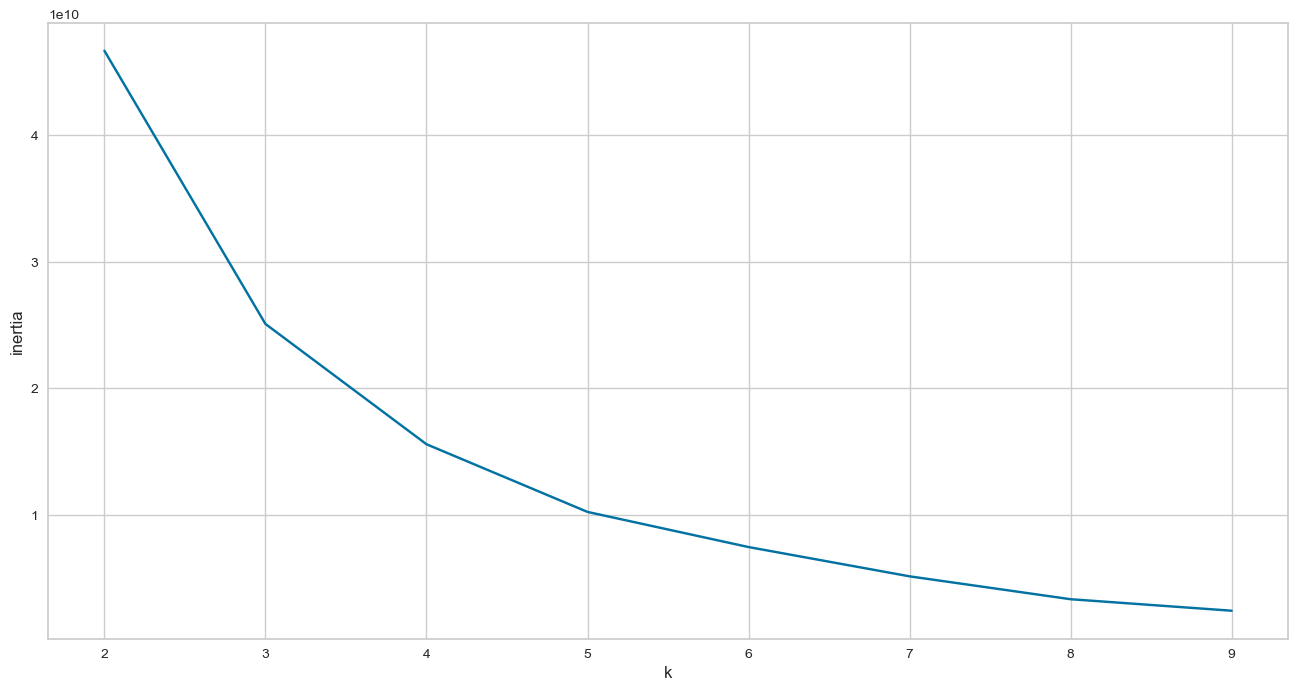

In [46]:
K = range(2, 10)

inertia = []

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=21)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

inertia

plt.figure(figsize=(16,8))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.show()

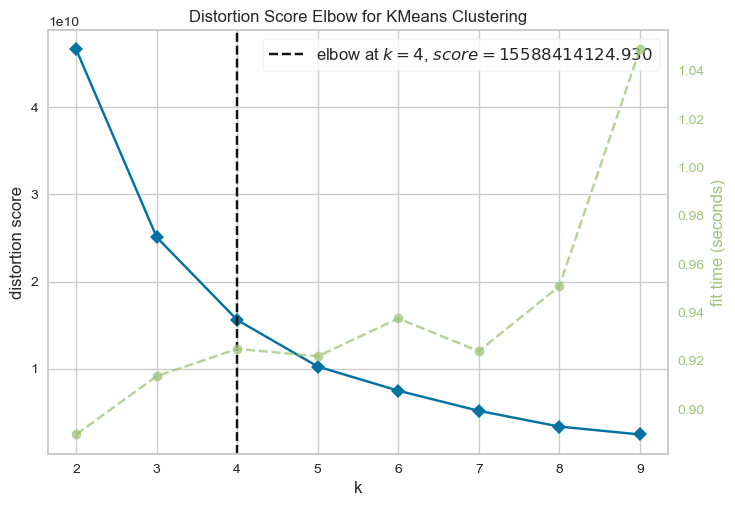

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [47]:
visualizer = KElbowVisualizer(kmeans, k=(2,10))

visualizer.fit(X) 
visualizer.poof()

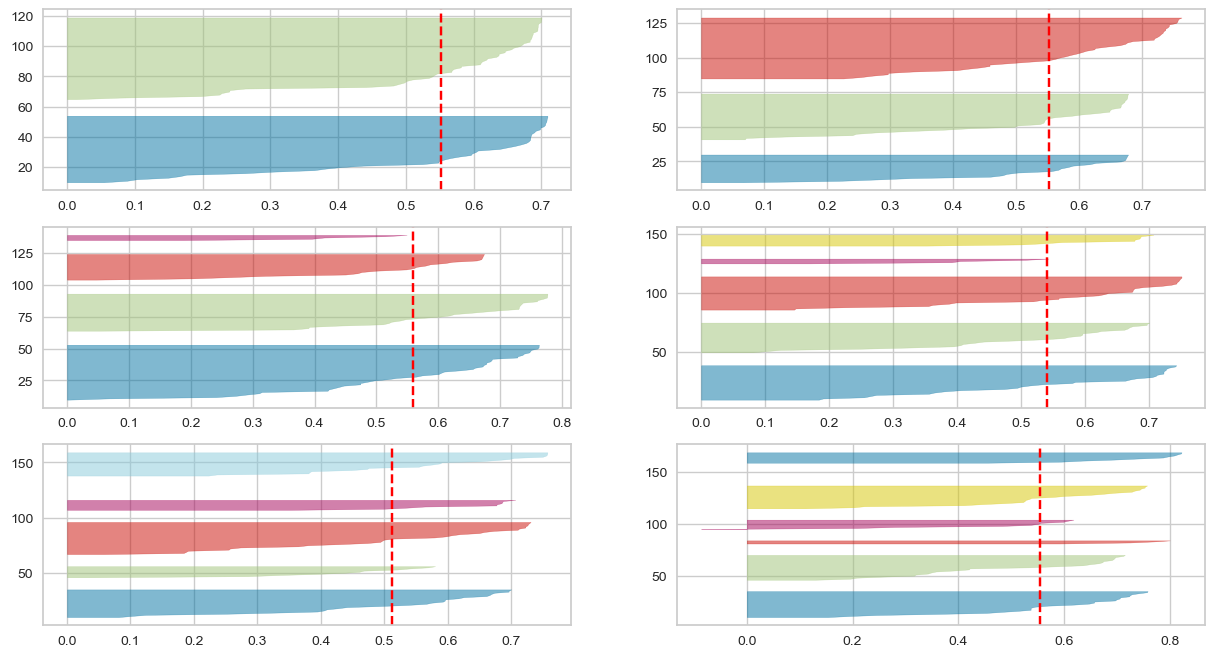

In [51]:
fig, ax = plt.subplots(3,2, figsize=(15,8))
for i in [2,3,4,5,6,7]:
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i,2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(X)

In [78]:
# Predicting a model with k=4

# train and predict
kmeans_4 = KMeans(n_clusters=3, random_state=42)
kmeans_4.fit(x_prep)
clusters = kmeans_4.predict(x_prep)

In [79]:
#create new dataframe with title, artist and cluster assigned
billboard_scaled_4 = pd.DataFrame(x_prep, columns=X.columns)
billboard_scaled_4['track_name'] = billboard['track_name']
billboard_scaled_4['album'] = billboard['album']
billboard_scaled_4['artist'] = billboard['artist']
billboard_scaled_4['cluster'] = clusters
billboard_scaled_4

,danceability,energy,key,loudness,mode,speechiness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,track_name,album,artist,cluster
0,-1.486969,0.127206,0.174575,0.437123,0.799590,-0.541319,-0.126462,-0.252033,-0.092407,2.855909,-0.907265,0.258199,Last Night,One Thing At A Time,Morgan Wallen,1
1,0.203483,0.167418,-1.600767,1.058265,0.799590,-0.272404,-0.126382,-1.194551,0.638288,-0.254340,0.125977,0.258199,Flowers,Flowers,Miley Cyrus,1
2,0.242796,-0.355345,0.766356,0.401974,0.799590,-0.663729,-0.126462,-0.483800,0.742673,-0.979859,1.962042,0.258199,Fast Car,Gettin' Old,Luke Combs,0
3,0.942565,1.005180,1.654027,0.574422,0.799590,-0.549030,-0.116109,-0.492384,1.316790,-0.653276,1.223105,0.258199,Calm Down (with Selena Gomez),Calm Down (with Selena Gomez),Rema,1
4,1.162716,-1.474594,-0.713096,-1.072621,0.799590,2.235542,-0.126462,-0.652045,0.842709,0.653493,0.768196,0.258199,All My Life (feat. J. Cole),All My Life (feat. J. Cole),Lil Durk,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-0.032394,-1.689061,-1.600767,-1.812390,0.799590,-0.656018,-0.126462,0.666449,-0.627380,-1.520490,1.262769,-2.323790,Save Me,Self Medicated,Jelly Roll,0
96,0.801038,0.489119,0.174575,1.484442,-1.250641,-0.250236,-0.122253,-0.612559,0.351229,1.557880,0.569000,0.258199,Yandel 150,Yandel 150,Yandel,1
97,0.683100,-0.080559,-0.121315,-0.230152,-1.250641,0.394582,-0.113509,0.014069,0.133761,-1.086629,-0.040923,0.258199,BESO,RR,ROSALÍA,2
98,0.006919,1.025286,-1.008986,1.371308,0.799590,-0.517223,-0.125728,-0.767070,1.255899,0.687874,-0.401598,0.258199,I Wrote The Book,3 Songs At A Time Sampler,Morgan Wallen,1


In [80]:
billboard_scaled_4['cluster'].value_counts()

1    45
0    36
2    19
Name: cluster, dtype: int64

In [81]:
score1 = silhouette_score(X, kmeans_4.labels_, metric='euclidean') 
print('Silhouetter Score: %.3f' % score1)

Silhouetter Score: 0.039


In [82]:
clusters = kmeans_4.predict(x_prep)
clusters

array([1, 1, 0, 1, 2, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 2, 1, 1, 1, 0, 1, 1,
       1, 1, 0, 0, 1, 0, 2, 1, 1, 1, 2, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1,
       2, 0, 0, 0, 0, 0, 0, 2, 1, 0, 1, 0, 1, 0, 1, 2, 0, 2, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 2, 2, 2, 0, 0, 1, 2, 1, 0, 2, 1, 1, 0, 0, 2, 2, 2,
       1, 1, 2, 0, 2, 1, 0, 0, 1, 2, 1, 0])

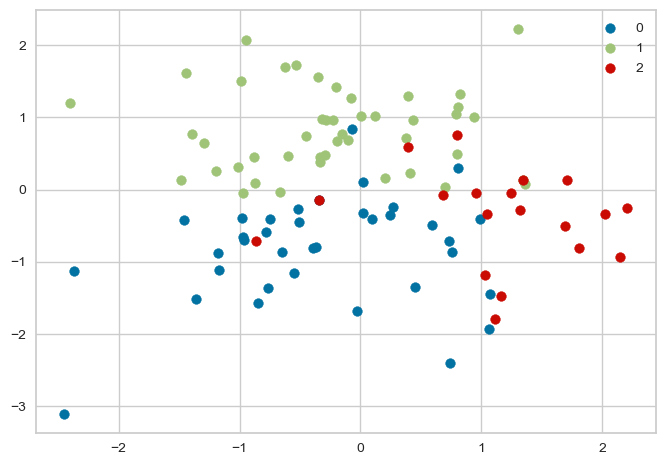

In [83]:
labels = np.unique(clusters)

for i in labels:
    plt.scatter(x_prep[clusters == i , 0] , x_prep[clusters == i , 1] , label = i)
plt.legend()
plt.show()

 - Function to return the song cluster

In [100]:
def song(billboard, billboard_scaled_4):
    user_input = input("Enter a song name: ")

    if user_input in billboard['track_name'].values:
        # Retrieve the respective song cluster value from df2
        cluster_value = billboard_scaled_4.loc[billboard_scaled_4['track_name'] == user_input, 'cluster'].values[0]
        return print("The song is in :", cluster_value, "cluser")
        play_song(user_input)
    else:
        return print("Given song is not in the Billboard Hot 100")
    
    

In [101]:
song(billboard, billboard_scaled_4)

Enter a song name: Last Night
The song is in : 1 cluser


In [98]:
song(billboard, billboard_scaled_4)

Enter a song name: Soniyo
Given song is not in the Billboard Hot 100
